In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.stats import nbinom
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col
from sklearn.preprocessing import StandardScaler
import datetime

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

<u> Preguntas (todas tienen el mismo puntaje): </u> 

1. Cargar la base de datos en el ambiente. Identifique los tipos de datos que se encuentran en la base, realice estadisticas descriptivas sobre las variables importantes (Hint: Revisar la distribuciones, datos faltantes, outliers, etc.) y limpie las variables cuando sea necesario. 

2. Ejecute un modelo de probabilidad lineal (*MCO*) que permita explicar la probabilidad de que un dia se reporte fallo medido por sensor, a partir de las informacion disponible. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

3. Ejecute un modelo *probit* para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

4. Ejecute un modelo *logit*  para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

5. Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

6. Agregue la data a nivel mensual, usando la data promedio de las variables (ignorando aquellas categoricas, como la direccion del viento). En particular, genere una variable que cuente la cantidad de fallos observados en un mes, utilice un valor de 0 si en ese mes no se reporto fallos en ningun dia. Use un modelo Poisson para explicar el numero de fallas por mes. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

7. Determine sobre dispersion en la data y posible valor optimo de alpha para un modelo Binomial Negativa.

8. Usando la informacion anterior, ejecute un modelo Binomial Negativa para responder a la pregunta 6. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

9. Comente los resultados obtenidos en 6, 7 y 8. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

1. Cargar la base de datos en el ambiente. Identifique los tipos de datos que se encuentran en la base, realice estadisticas descriptivas sobre las variables importantes (Hint: Revisar la distribuciones, datos faltantes, outliers, etc.) y limpie las variables cuando sea necesario. 

__R:__ Se leyeron los datos con pandas, para luego realizar una limpieza que consistio en:
-Eliminar los NaN de filas que podian resultar muy relevantes para el análisis
-Eliminar NaN del resto de filas (Con un porcentaje de NaN igual o menor al 10%)
-Crear variables dicotómicas que indicaban si es que faltaban datos en ciertas columnas o no (Las que tenian un porcentaje de NaN mayor al 10%)
-Se elimino el "Parameter6_9am" y el "Parameter6_3pm" debido a que ensuciaban mucho la data, y se conservo su dicotomica indicadora
-Se simplificaron las variables cardinales de 16 puntos a 4 solamente (N,W,S,E)
-Se crearon columnas usando de base la columna "Date" creando así 2 columnas, una llamada "Season" indicando la estación del año y otra llamada "Year" indicando el año en el que se registro el dato
-Se transformo la columna de "Failure_today" a dicotomica
-Se aplico log(1+x) a la columna "Leakage" para dejar su distribución de forma más uniforme
-Se estandarizaron las columnas "Parameter4_9am", "Parameter4_3pm" debido a su alta varianza
-Se eliminaron las variables "Location" con los valores 17, 18, 26, 42 para dejar los datos distribuidos de la variable de una forma mucho más uniforme


In [2]:
df = pd.read_csv('../../data/machine_failure_data.csv', delimiter=",", decimal='.')


In [3]:
df

,Date,Location,Min_Temp,Max_Temp,Leakage,Evaporation,Electricity,Parameter1_Dir,Parameter1_Speed,Parameter2_9am,...,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Parameter5_3pm,Parameter6_9am,Parameter6_3pm,Parameter7_9am,Parameter7_3pm,Failure_today
0,12/1/2008,3,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No
1,12/2/2008,3,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No
2,12/3/2008,3,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No
3,12/4/2008,3,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No
4,12/5/2008,3,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,6/20/2017,42,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,13.0,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No
142189,6/21/2017,42,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No
142190,6/22/2017,42,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No
142191,6/23/2017,42,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No


In [4]:
#Se eliminaron las filas que tenian un NaN que dificultaban el analisis de los datos

#Se elimino los que no tenian temperatura minima, ya que la temperatura resulta un dato muy relevante a la hora de buscar motivo de falla,
#por lo cual las filas sin la debida información no nos sirven
df = df[df["Min_Temp"].notna()]

#Lo mismo de arriba aplica para la temperatura máxima
df = df[df["Max_Temp"].notna()]

#Las filtraciones son un dato extremadamente importante para detectar fallas, por lo cual deberíamos eliminar las filas con NaN
df = df[df["Leakage"].notna()]


In [5]:
#Se eliminaron las filas que tenian un NaN que dificultaban el analisis de los datos

#Se elimino los que no tenian temperatura minima, ya que la temperatura resulta un dato muy relevante a la hora de buscar motivo de falla,
#por lo cual las filas sin la debida información no nos sirven
df = df[df["Min_Temp"].notna()]

#Lo mismo de arriba aplica para la temperatura máxima
df = df[df["Max_Temp"].notna()]

#Las filtraciones son un dato extremadamente importante para detectar fallas, por lo cual deberíamos eliminar las filas con NaN
df = df[df["Leakage"].notna()]

#Eliminamos los NaN de los parametros medidos, ya que no son tantos datos NaN (Menores o iguales al 10%)
df = df[df["Parameter1_Dir"].notna()]
df = df[df["Parameter1_Speed"].notna()]
df = df[df["Parameter2_9am"].notna()]
df = df[df["Parameter2_3pm"].notna()]
df = df[df["Parameter3_9am"].notna()]
df = df[df["Parameter3_3pm"].notna()]
df = df[df["Parameter4_9am"].notna()]
df = df[df["Parameter4_3pm"].notna()]
df = df[df["Parameter5_9am"].notna()]
df = df[df["Parameter5_3pm"].notna()]
df = df[df["Parameter7_9am"].notna()]
df = df[df["Parameter7_3pm"].notna()]

In [6]:
#Creamos 2 columnas dicotomicas que nos indican si es que un dato cualquiera esta presente en las columnas "Parameter6_9am"(38% de NaN) 
#y "Parameter6_3pm"(40% de NaN) 1 si es que esta el dato, 0 si es NaN:
nueva_columna=[]
for i in df["Parameter6_9am"]:
    if pd.isna(i):
        nueva_columna.append(0)
    else:
        nueva_columna.append(1)

df["Parameter6_9am_Bin"]=nueva_columna

nueva_columna=[]
for i in df["Electricity"]:
    if pd.isna(i):
        nueva_columna.append(0)
    else:
        nueva_columna.append(1)

df["Parameter6_3pm_Bin"]=nueva_columna

#Eliminamos los parametros 6 ya que ensucian mucho los datos
df = df.drop("Parameter6_3pm", axis=1)
df = df.drop("Parameter6_9am", axis=1)

In [7]:
#Creamos 2 columnas dicotomicas que nos indican si es que un dato cualquiera esta presente en las columnas "Evaporation" y "Electricity"
#1 si es que esta el dato, 0 si es NaN:
nueva_columna=[]
for i in df["Evaporation"]:
    if pd.isna(i):
        nueva_columna.append(0)
    else:
        nueva_columna.append(1)

df["EvaporationBin"]=nueva_columna

nueva_columna=[]
for i in df["Electricity"]:
    if pd.isna(i):
        nueva_columna.append(0)
    else:
        nueva_columna.append(1)

df["ElectricityBin"]=nueva_columna


In [8]:
#Se transforman los puntos cardinales con 3 letras y 2 letras a una solamente(Si es NNW [north-northwest], lo dejamos como N [north])
def transforman_cardinales(columna):
    nueva_columna = []
    for i in columna:
        if isinstance(i, str) and len(i) == 3:
            nueva_columna.append(i[:-2])
        elif isinstance(i, str) and len(i) == 2:
            nueva_columna.append(i[:-1])
        else:
            nueva_columna.append(i)
    return nueva_columna
df["Parameter1_Dir"]=transforman_cardinales(df["Parameter1_Dir"])

df["Parameter2_9am"]=transforman_cardinales(df["Parameter2_9am"])

df["Parameter2_3pm"]=transforman_cardinales(df["Parameter2_3pm"])


In [9]:
#Creamos una columna con los años:
df["Year"] = df["Date"].apply(lambda x: x.split('/')[-1])

#Eliminamos de la data los años que no tengan los 12 meses correspondientes:
df = df[df["Year"] != 2008]
df = df[df["Year"] != 2017]

#Clasificamos por estación
nueva_columna=[]
#Se considera que una estación dura exactamente 3 meses, y que el invierno empieza en enero
for i in df["Date"]:
    mes = int(i.split('/')[0])
    if mes>=1 and mes<4:
        nueva_columna.append("Winter")
    elif mes>=4 and mes<7:
        nueva_columna.append("Spring")
    elif mes>=7 and mes<10:
        nueva_columna.append("Summer")
    else:
        nueva_columna.append("Autumn")

df["Season"]=nueva_columna
df['Date'] = pd.to_datetime(df['Date'])
#Pasamos year de object a entero para evitar errores
df["Year"] = df["Year"].astype(int)


In [10]:
nueva_columna=[]
for i in df["Failure_today"]:
    if i=="No":
        nueva_columna.append(0)
    else:
        nueva_columna.append(1)

df["Failure_today"]=nueva_columna
df["Failure_today"].value_counts()

Failure_today
0    87556
1    25369
Name: count, dtype: int64

In [11]:
df["Season"] = df["Season"].astype('category')
df=pd.get_dummies(df, columns=["Season"], drop_first=True)

In [12]:
df["Leakage"] = np.log1p(df["Leakage"])

In [13]:
df_varianza=df.drop(["Date","Parameter2_3pm","Parameter2_9am","Parameter1_Dir"], axis=1)
df_varianza.var()

Location              208.907260
Min_Temp               39.114199
Max_Temp               48.758134
Leakage                 0.823964
Evaporation            17.710590
Electricity            14.260742
Parameter1_Speed      177.469652
Parameter3_9am         69.627406
Parameter3_3pm         73.618072
Parameter4_9am        357.648986
Parameter4_3pm        431.332665
Parameter5_9am         49.458223
Parameter5_3pm         48.411286
Parameter7_9am         40.386593
Parameter7_3pm         46.749766
Failure_today           0.174186
Parameter6_9am_Bin      0.221237
Parameter6_3pm_Bin      0.241870
EvaporationBin          0.231601
ElectricityBin          0.241870
Year                    6.401925
Season_Spring           0.186416
Season_Summer           0.183233
Season_Winter           0.192972
dtype: float64

In [14]:
#Estandarizamos las columnas de alta varianza:
columnas_a_estandarizar=["Parameter4_9am","Parameter4_3pm"]
scaler=StandardScaler()
df[columnas_a_estandarizar] = scaler.fit_transform(df[columnas_a_estandarizar])


In [15]:
#Vamos a eliminar las variables con una frecuencia menor a 2000 para dejar los datos de una forma mucho más uniforme:
locaciones_a_eliminar = [17, 18, 26, 42]
indices_a_eliminar = df[df['Location'].isin(locaciones_a_eliminar)].index
df = df.drop(indices_a_eliminar)

In [16]:
df=pd.get_dummies(df, columns=["Parameter1_Dir"], drop_first=True)

df=pd.get_dummies(df, columns=["Parameter2_9am"], drop_first=True) 

df=pd.get_dummies(df, columns=["Parameter2_3pm"], drop_first=True) 

In [17]:
#Para la matriz de correlaciones del anexo
dfcorrelaciones=df

In [18]:
df=pd.get_dummies(df, columns=["Location"], drop_first=True)

2. Ejecute un modelo de probabilidad lineal (*MCO*) que permita explicar la probabilidad de que un dia se reporte fallo medido por sensor, a partir de las informacion disponible. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

__R:__ Guíandome por la matriz de correlaciones, elimine del modelo las variables con alta correlación entre si (mayor a 0.8), y elimine la variable leakage (Debido a su predicción practicamente perfecta, lo mismo se realizo para el resto de modelos en el trabajo), de los parametros que tenian p>0.05.
Las conclusiones son:
-El modelo MCO es capaz de explicar un 28.8% de los datos
-Si aumenta en 1 grado la temperatura mínima, la probabilidad de fallo aumenta en un 1.63%
-Si disminuye en 1 grado la temperatura máxima, la probabilidad de fallo disminuye en un 1.68%
-Si la velocidad del viento aumenta en una milla por hora,a probabilidad de fallo aumenta en un 0.053%
-Y asi se realizo la misma interpretación con el resto de parametros significativos, multiplicando su valor por 100 e interpretando el resultado como su variación porcentual.
-Cabe destacar que cada locación tenia influencias completamente distintas en la explicación de la falla, por lo cual habria que revisar la locación de interes en cada paso en particular para realizar las estimaciones.

In [19]:
#Regresion excluyendo variables de alta correlacion y las con NaN
y=df['Failure_today']
X=df.drop(['Failure_today','Date','Leakage', 'Parameter5_3pm','Parameter7_3pm','Parameter7_9am','Parameter6_3pm_Bin','Evaporation','Electricity'], axis=1)
X = X.astype(float) 
X=sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit(cov_type='HC0')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          Failure_today   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     714.2
Date:                Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                        21:55:24   Log-Likelihood:                -40899.
No. Observations:              107753   AIC:                         8.193e+04
Df Residuals:                  107689   BIC:                         8.254e+04
Df Model:                          63                                         
Covariance Type:                  HC0                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  7.8930      0

3. Ejecute un modelo *probit* para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

__R:__ Para el modelo probit se utilizaron las mismas variables que en el MCO, para poder comparar la efectividad de los modelos y sus diferencias en 5.

Las conclusiones son:
-El modelo probit es capaz de explicar un 32.74% de los datos
-Si aumenta en 1 grado la temperatura mínima, la probabilidad de fallo aumenta en un 1.92%
-Si disminuye en 1 grado la temperatura máxima, la probabilidad de fallo disminuye en un 2.40%
-De el resto de parametros cabe destacar el Parameter4_9am, que al subir en 1 unidad tiene un efecto del aumentar la probabilidad de fallo en un 16.04%, por lo que es una variable relevante.
-La dirección del viento tambien resulta relevante, teniendo direccion "West" a las 9am provoca un aumento 4.92% de falla, y teniendo la direccion "South" a la misma hora provocaba un aumento en la probabilidad de falla de un 3.95%
-Se detectan porcentajes de falla relevantes respecto a las estaciones, con un 5.69% de probablidad disminución de falla en "Spring" y 3.93% en "Summer" y 3.62% en "Winter", por lo que es probable que las fallas sean más propensas a suceder en "Autumn".
-Y asi se realizo la misma interpretación con el resto de parametros significativos, multiplicando su valor por 100 e interpretando el resultado como su variación porcentual.
-Al igual que en el modelo anterior cada locación tiene influencias completamente distintas en la explicación de la falla, por lo cual habria que revisar la locación de interes en cada paso en particular para realizar las estimaciones.

In [20]:
model = sm.Probit(y, X)
probit_model = model.fit(cov_type='HC0')
print(probit_model.summary())

mfxp = probit_model.get_margeff()
print(mfxp.summary())

Optimization terminated successfully.
         Current function value: 0.360727
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:               107753
Model:                         Probit   Df Residuals:                   107689
Method:                           MLE   Df Model:                           63
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.3274
Time:                        21:55:25   Log-Likelihood:                -38869.
converged:                       True   LL-Null:                       -57786.
Covariance Type:                  HC0   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 28.3195      4.594      6.164      0.000      19.315      37.324
Min_T

4. Ejecute un modelo *logit*  para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

__R:__ Para el modelo logit se utilizaron las mismas variables que en los 2 modelos anteriores, para poder compararlos en 5.

Las conclusiones son:
-El modelo probit es capaz de explicar un 32.96% de los datos
-Si aumenta en 1 grado la temperatura mínima, la probabilidad de fallo aumenta en un 1.94%
-Si disminuye en 1 grado la temperatura máxima, la probabilidad de fallo disminuye en un 2.49%
-De el resto de parametros cabe destacar que otra vez el Parameter4_9am es altamente influyente, al subir en 1 unidad este tiene un efecto del aumentar la probabilidad de fallo en un 16.31%, por lo que es una variable relevante.
-La dirección del viento vuelve a ser relevante mayormente en las mismas direcciones analizadas anteriormente y a la misma hora (9am), teniendo direccion "West" provoca un aumento 4.93% de falla, y la direccion "South" de un provoca un aumento del 3.93% en la probabilidad de falla
-Acá igualmente se detectan porcentajes de falla relevantes respecto a las estaciones, con un 5.40% de probablidad disminución de falla en "Spring" y 3.82% en "Summer" y 3.33% en "Winter", por lo que es probable que las fallas sean más propensas a suceder en "Autumn".
-Y asi se realizo la misma interpretación con el resto de parametros significativos, multiplicando su valor por 100 e interpretando el resultado como su variación porcentual.
-Al igual que los modelos anteriores, cada locación tiene influencias completamente distintas en la explicación de la falla, por lo cual habria que revisar la locación de interes en cada paso en particular caso para realizar las estimaciones.

In [21]:
model = sm.Logit(y, X)
logit_model = model.fit(cov_type='HC0')
print(logit_model.summary())

mfxl = logit_model.get_margeff()
print(mfxl.summary())

params = logit_model.params
conf = logit_model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['Odds Ratio', '5%', '95%']
print("Odds Ratios")
print(np.exp(conf).iloc[1:17 , ])


Optimization terminated successfully.
         Current function value: 0.359504
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:               107753
Model:                          Logit   Df Residuals:                   107689
Method:                           MLE   Df Model:                           63
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.3296
Time:                        21:55:47   Log-Likelihood:                -38738.
converged:                       True   LL-Null:                       -57786.
Covariance Type:                  HC0   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 50.2301      8.114      6.190      0.000      34.326      66.134
Min_T

5. Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

__R:__ Existen diferencias entre los resultados mayormente entre el MCO y los otros modelos, y esto sucede debido a que el MCO no es tan bueno explicando variables binarias (Indicadora de falla en este caso), por lo cual el logit y el probit son más especificos a la hora de realizar mediciones.
El que resulto mejor estimador para las variables es el modelo logit, ya que es el que explica el mayor porcentaje de datos (un 32.96% de estos), y las variables de interes terminaron siendo: La temperatura mínima y máxima, el Parameter4 a las 9am, la dirección del viento en "West" y "South" y las estaciones del año.



6. Agregue la data a nivel mensual, usando la data promedio de las variables (ignorando aquellas categoricas, como la direccion del viento). En particular, genere una variable que cuente la cantidad de fallos observados en un mes, utilice un valor de 0 si en ese mes no se reporto fallos en ningun dia. Use un modelo Poisson para explicar el numero de fallas por mes. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

__R:__ Se eliminaron las variables dummies para el análisis de Poisson, según el R cuadrado se logro una estimación practicamente perfecta (Pseudo R-squ.(CS):0.9999), se estimo un número base de fallas mensuales de 33.48, un aumento en una unidad de las siguientes variables significaria lo siguiente para la cantidad de fallas:
-La temperatura mínima: 0.1375 fallas más al mes
-La temperatura máxima: 0.1344 fallas menos fallas al mes
-Parameter3_3pm: 0.1044 fallas más al mes
-Parameter4_3pm: 0.7000 fallas más al mes
-Parameter6_9am_Bin: 0.9659 fallas menos al mes si es que existen datos medibles en el parametro

In [22]:
df_filtrado = df[~((df['Date'].dt.year == 2008) | (df['Date'].dt.year == 2017)| (df['Date'].dt.year == 2007))].copy()

In [23]:
df_filtrado = df_filtrado.drop(columns=['Evaporation', 'Electricity'])

In [24]:
# 1. Establecer la columna 'Date' como índice
df_filtrado = df_filtrado.set_index('Date')
# 2. Guardamos las fallas por mes
Month_failures = df_filtrado.resample('M')['Failure_today'].sum().rename('Month_failures')
# 3. Resamplear por mes ('M') y calcular la media
df_promedios_mensuales = df_filtrado.resample('M').mean()
df_promedios_mensuales

,Min_Temp,Max_Temp,Leakage,Parameter1_Speed,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Parameter5_3pm,...,Location_39,Location_40,Location_41,Location_43,Location_44,Location_45,Location_46,Location_47,Location_48,Location_49
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-31,17.284982,30.417446,0.312276,45.338129,15.934353,21.382194,-0.510110,-0.476173,1013.302878,1011.060072,...,0.026978,0.026978,0.025180,0.027878,0.026978,0.027878,0.026978,0.025180,0.027878,0.027878
2009-02-28,17.687712,29.236364,0.494175,43.653347,15.652348,20.935065,-0.194426,-0.232030,1013.314985,1011.203197,...,0.024975,0.025974,0.021978,0.027972,0.024975,0.026973,0.027972,0.024975,0.027972,0.027972
2009-03-31,15.636965,26.985847,0.366321,40.877095,14.691806,19.749534,-0.011721,-0.199529,1016.438361,1014.295717,...,0.024209,0.028864,0.021415,0.027933,0.026071,0.025140,0.025140,0.022346,0.026071,0.027002
2009-04-30,12.818879,23.408879,0.513873,39.967290,15.025234,19.053271,0.011591,-0.027310,1018.444019,1015.915981,...,0.023364,0.026168,0.025234,0.026168,0.025234,0.025234,0.027103,0.027103,0.026168,0.027103
2009-05-31,10.324079,20.369027,0.443316,37.110482,14.423041,17.848914,0.232282,0.136787,1022.030784,1019.601794,...,0.027384,0.027384,0.020774,0.026440,0.021719,0.025496,0.025496,0.021719,0.026440,0.029273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-31,8.135900,18.115219,0.609507,39.590868,14.658908,18.843330,0.292866,0.229614,1020.217189,1017.685497,...,0.025962,0.026858,0.017905,0.027753,0.020591,0.025067,0.027753,0.023277,0.026858,0.027753
2016-09-30,9.867712,19.173063,0.743319,40.232472,15.367159,19.283210,0.227262,0.397936,1016.084686,1013.461070,...,0.027675,0.024908,0.023063,0.025830,0.023063,0.023985,0.011993,0.024908,0.027675,0.027675
2016-10-31,10.773516,22.074225,0.512511,46.434012,17.712135,22.765279,-0.287072,-0.083734,1015.570771,1013.375908,...,0.027458,0.023915,0.020372,0.026572,0.022143,0.024801,0.019486,0.025686,0.027458,0.026572


In [25]:
Month_failures

Date
2009-01-31    141
2009-02-28    192
2009-03-31    195
2009-04-30    246
2009-05-31    209
             ... 
2016-08-31    330
2016-09-30    378
2016-10-31    298
2016-11-30    158
2016-12-31    207
Freq: ME, Name: Month_failures, Length: 96, dtype: int64

In [26]:
#Eliminamos los meses sin datos:
df_promedios_mensuales=df_promedios_mensuales.dropna()

In [27]:
df_promedios_mensuales

,Min_Temp,Max_Temp,Leakage,Parameter1_Speed,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Parameter5_3pm,...,Location_39,Location_40,Location_41,Location_43,Location_44,Location_45,Location_46,Location_47,Location_48,Location_49
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-31,17.284982,30.417446,0.312276,45.338129,15.934353,21.382194,-0.510110,-0.476173,1013.302878,1011.060072,...,0.026978,0.026978,0.025180,0.027878,0.026978,0.027878,0.026978,0.025180,0.027878,0.027878
2009-02-28,17.687712,29.236364,0.494175,43.653347,15.652348,20.935065,-0.194426,-0.232030,1013.314985,1011.203197,...,0.024975,0.025974,0.021978,0.027972,0.024975,0.026973,0.027972,0.024975,0.027972,0.027972
2009-03-31,15.636965,26.985847,0.366321,40.877095,14.691806,19.749534,-0.011721,-0.199529,1016.438361,1014.295717,...,0.024209,0.028864,0.021415,0.027933,0.026071,0.025140,0.025140,0.022346,0.026071,0.027002
2009-04-30,12.818879,23.408879,0.513873,39.967290,15.025234,19.053271,0.011591,-0.027310,1018.444019,1015.915981,...,0.023364,0.026168,0.025234,0.026168,0.025234,0.025234,0.027103,0.027103,0.026168,0.027103
2009-05-31,10.324079,20.369027,0.443316,37.110482,14.423041,17.848914,0.232282,0.136787,1022.030784,1019.601794,...,0.027384,0.027384,0.020774,0.026440,0.021719,0.025496,0.025496,0.021719,0.026440,0.029273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-31,8.135900,18.115219,0.609507,39.590868,14.658908,18.843330,0.292866,0.229614,1020.217189,1017.685497,...,0.025962,0.026858,0.017905,0.027753,0.020591,0.025067,0.027753,0.023277,0.026858,0.027753
2016-09-30,9.867712,19.173063,0.743319,40.232472,15.367159,19.283210,0.227262,0.397936,1016.084686,1013.461070,...,0.027675,0.024908,0.023063,0.025830,0.023063,0.023985,0.011993,0.024908,0.027675,0.027675
2016-10-31,10.773516,22.074225,0.512511,46.434012,17.712135,22.765279,-0.287072,-0.083734,1015.570771,1013.375908,...,0.027458,0.023915,0.020372,0.026572,0.022143,0.024801,0.019486,0.025686,0.027458,0.026572


In [28]:
#Eliminamos las variables categoricas
prefijo_a_eliminar = 'Season_'  # Ejemplo: eliminar todas las dummies que comiencen con 'Season_'
columnas_a_mantener = [col for col in df_promedios_mensuales.columns if not col.startswith(prefijo_a_eliminar)]
df_promedios_mensuales = df_promedios_mensuales[columnas_a_mantener]

prefijo_a_eliminar = 'Parameter1_Dir_'  # Ejemplo: eliminar todas las dummies que comiencen con 'Season_'
columnas_a_mantener = [col for col in df_promedios_mensuales.columns if not col.startswith(prefijo_a_eliminar)]
df_promedios_mensuales = df_promedios_mensuales[columnas_a_mantener]

prefijo_a_eliminar = 'Parameter2_9am_'  # Ejemplo: eliminar todas las dummies que comiencen con 'Season_'
columnas_a_mantener = [col for col in df_promedios_mensuales.columns if not col.startswith(prefijo_a_eliminar)]
df_promedios_mensuales = df_promedios_mensuales[columnas_a_mantener]

prefijo_a_eliminar = 'Parameter2_3pm_'  # Ejemplo: eliminar todas las dummies que comiencen con 'Season_'
columnas_a_mantener = [col for col in df_promedios_mensuales.columns if not col.startswith(prefijo_a_eliminar)]
df_promedios_mensuales = df_promedios_mensuales[columnas_a_mantener]

prefijo_a_eliminar = 'Location_'  # Ejemplo: eliminar todas las dummies que comiencen con 'Season_'
columnas_a_mantener = [col for col in df_promedios_mensuales.columns if not col.startswith(prefijo_a_eliminar)]
df_promedios_mensuales = df_promedios_mensuales[columnas_a_mantener]

In [29]:
df_resultado = pd.concat([Month_failures, df_promedios_mensuales], axis=1)

In [30]:
#Volvemos a aplicar un dropna() para asegurarnos de la limpieza de los datos
df_resultado=df_resultado.dropna()

In [31]:
y = df_resultado['Month_failures']
X2=df_resultado.drop(['Month_failures','Failure_today','Leakage', 'Parameter5_3pm','Parameter7_3pm','Parameter7_9am','Parameter6_3pm_Bin'], axis=1)
X2=sm.add_constant(X2)
X2 = X2.astype(float) 
poisson=sm.GLM(y,X2,family=sm.families.Poisson()).fit()
print(poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         Month_failures   No. Observations:                   93
Model:                            GLM   Df Residuals:                       80
Model Family:                 Poisson   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -457.57
Date:                Thu, 24 Apr 2025   Deviance:                       234.87
Time:                        21:55:56   Pearson chi2:                     233.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 33.4812     13

7. Determine sobre dispersion en la data y posible valor optimo de alpha para un modelo Binomial Negativa.

__R:__ El valor de alpha obtenido es de 1.0062192597829778, lo cual nos indica una posible sobredispersión en los datos.

In [32]:
predictions = poisson.predict(X2)
print(predictions)

Date
2009-01-31    155.392452
2009-02-28    211.882443
2009-03-31    197.420731
2009-04-30    226.380931
2009-05-31    230.264015
                 ...    
2016-08-31    278.677377
2016-09-30    359.267860
2016-10-31    281.347064
2016-11-30    216.433250
2016-12-31    221.732798
Length: 93, dtype: float64


In [33]:
aux=((y-predictions)**2-predictions)/predictions
auxr=sm.OLS(aux,predictions).fit()
print(auxr.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.203
Model:                            OLS   Adj. R-squared (uncentered):              0.195
Method:                 Least Squares   F-statistic:                              23.46
Date:                Thu, 24 Apr 2025   Prob (F-statistic):                    5.14e-06
Time:                        21:55:56   Log-Likelihood:                         -236.08
No. Observations:                  93   AIC:                                      474.2
Df Residuals:                      92   BIC:                                      476.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [34]:
alfa=np.exp(0.0062)
print(alfa)

1.0062192597829778


8. Usando la informacion anterior, ejecute un modelo Binomial Negativa para responder a la pregunta 6. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

__R:__ El modelo da como resultado que las variables que tenemos no explican practicamente nada los datos, teniendo un R cuadrado de casi 0  (Pseudo R-squ.(CS):0.03762) y con valores p mayores a 0.739, por lo cual no hay variables a rescatar.

In [35]:
negbin = sm.GLM(y, X2, family=sm.families.NegativeBinomial(alpha=1.0062192597829778)).fit()
print(negbin.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         Month_failures   No. Observations:                   93
Model:                            GLM   Df Residuals:                       80
Model Family:        NegativeBinomial   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -603.29
Date:                Thu, 24 Apr 2025   Deviance:                      0.96419
Time:                        21:55:57   Pearson chi2:                    0.945
No. Iterations:                     5   Pseudo R-squ. (CS):            0.03762
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 30.0078    207

In [36]:
X2["Predictions"] = negbin.predict(X2).astype(float)
print(X2.Predictions)

Date
2009-01-31    152.519627
2009-02-28    210.092124
2009-03-31    195.928544
2009-04-30    228.341360
2009-05-31    232.350027
                 ...    
2016-08-31    277.530433
2016-09-30    358.196594
2016-10-31    276.458187
2016-11-30    211.116893
2016-12-31    218.300866
Name: Predictions, Length: 93, dtype: float64


9. Comente los resultados obtenidos en 6, 7 y 8. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

__R:__ En Poisson se obtienen resultados completamente opuestos que en un modelo de Binomial Negativa, el primero explicando por completo varias variables, y el segundo no siendo capaz de explicar 1, debido a que existe cierto nivel de sobredispersión, es mas recomendable ocupar Binomial Negativa, pero al darnos resultados tan poco conluyentes, en lo personal investigaría las variables que nos arrojo Poisson, ya que es lo mejor que tenemos para poder sacar algún tipo de conclusión, las cuales fueron: la temperatura mínima, la temperatura máxima, Parameter3_3pm, Parameter4_3pm y Parameter6_9am_Bin


__Anexos__

In [37]:
df_original = pd.read_csv('../../data/machine_failure_data.csv', delimiter=",", decimal='.')

Anexo 1: Gráfico de freuencias de cada locación

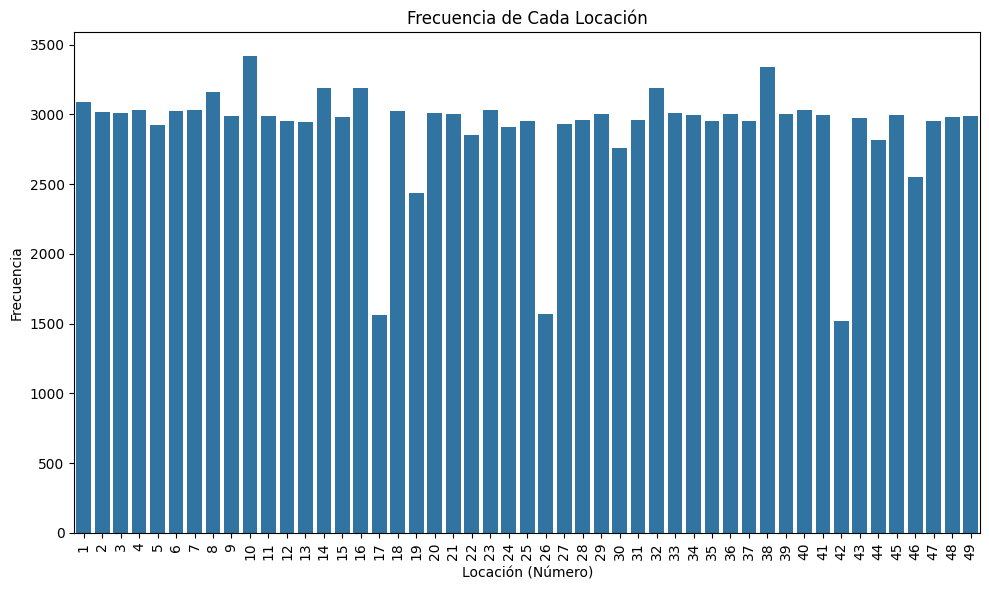

In [38]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Location', data=df_original)
plt.xlabel('Locación (Número)')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Cada Locación')
plt.xticks(rotation=90) # Rota las etiquetas del eje x si hay muchas locaciones
plt.tight_layout() # Ajusta el diseño para evitar que las etiquetas se superpongan
plt.show()


Anexo 2: Matriz de correlación

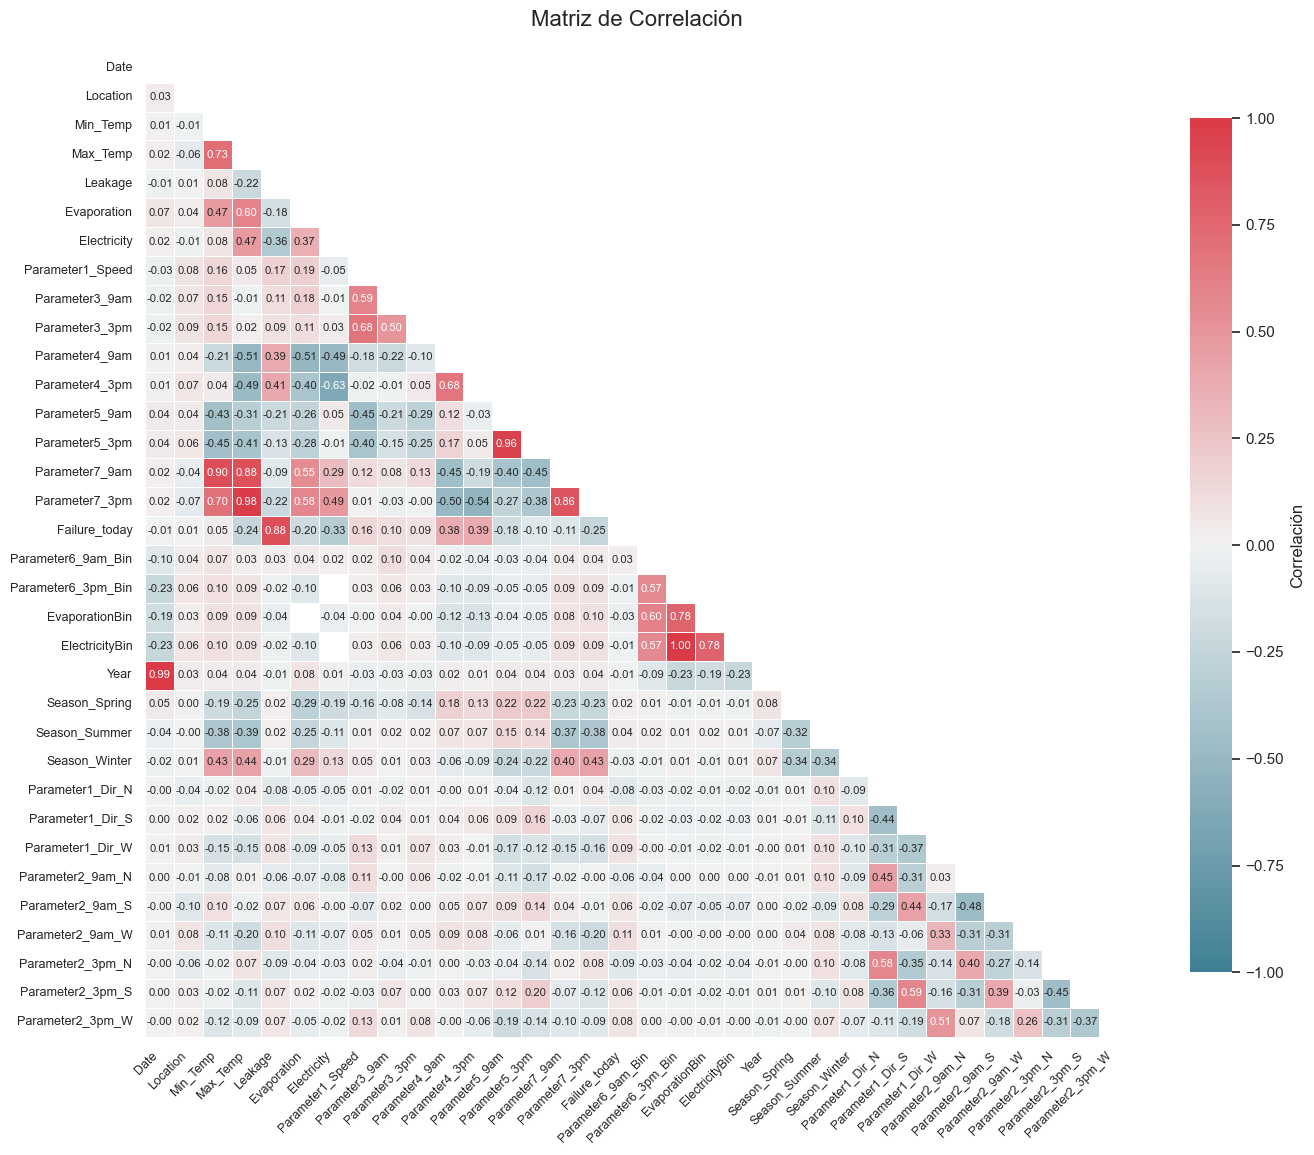

In [39]:
# Calcula la matriz de correlación
corr = dfcorrelaciones.corr()

# Máscara para la mitad superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Estilo de seaborn
sns.set(style="white")

# Tamaño del gráfico
f, ax = plt.subplots(figsize=(14, 12))

# Paleta de colores mejorada
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Mapa de calor
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1.0,
    vmin=-1.0,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, 'label': 'Correlación'},
    annot=True,  # Muestra los valores numéricos
    fmt=".2f",   # Dos decimales
    annot_kws={"size": 8}
)

# Rota las etiquetas del eje X
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)

# Título
plt.title("Matriz de Correlación", fontsize=16, pad=20)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Anexo 3: Grafico "plambda"

<Axes: xlabel='plambda', ylabel='Count'>

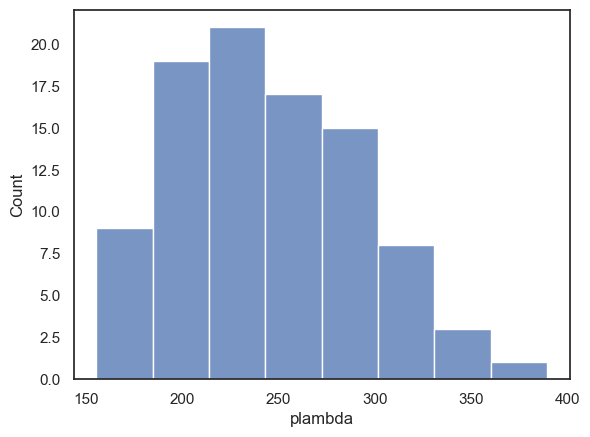

In [40]:
df_resultado['plambda'] = poisson.mu
sns.histplot(data=df_resultado, x="plambda")